Сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Задача заключается в классификации персонажей проживающих в Спрингфилде.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [ ]:
# мы проверим, включен ли графический процессор для этого ноутбука
# должно напечатать следующее: CUDA is available! Обучение на GPU ...
#
# если иначе, то вам нужно включить GPU:

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
'''
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
'''
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [ ]:
# открывем доступ коллабу к гугл диску, на котором лежат данные
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# загрузка данных в ноутбук
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
# выведем GPU на которой будут происходить вычисления
!nvidia-smi
import torch
torch.cuda.is_available()

Wed May 26 10:50:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
# импорт необходимых библиотек
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 299x299 px
RESCALE_SIZE = 299
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        # если режим не верный мы скажем
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        # количество картинок
        self.len_ = len(self.files)
        # создаем штучку типа oneHotEncoder'а, тока у нас не будут появляться 
        # столбцы на каждый признак, а будет 1 столбец с разными цифирами
        # https://habr.com/ru/post/456294/
        self.label_encoder = LabelEncoder()
        # имена картинок будут в переменной self.labels
        # self.files это пути к картинкам, тогда при помощи path.parent.name
        # получим их имена. Затем сделаем фит в энкодере
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            # при помощи пикла сериализуем(передаем) данные
            # экспорт LabelEncoder в виде файла .pkl для каждого столбца
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
    # вернем сколько всего картинок                  
    def __len__(self):
        return self.len_
    # загрузить картиночку для работы над ней 
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        # ресайз(преобразование изображения) я хочу сделать при помощи функций 
        # pytorch, работая с уже с тензорами
        # если режим работы это обучение и изменение параметров
        if self.mode == 'train': 
            # преобразование данных (размер, аугментация, нормализация)
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            # иначе если модель мы не обучаем а выполняем на ней предсказания
            # аугментации уже не будет, а будет нормализация и изменение размеров
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        # загружаем картинку обращаясь по пути
        x = self.load_sample(self.files[index])
        # применяем трансформацию обозначенную выше
        x = transform(x)
        # если тест то просто вернем сразу результат тк. правильной метки у нас нет
        if self.mode == 'test':
            return x
        else:
            # иначе возьмем метку по индексу
            label = self.labels[index]
            # переведем метку на понятный нам язык (язык боли)
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            # вернем и метку и файлик
            return x, y

In [ ]:
# вывод изображений
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# настройка путей, откуда мы будем брать данные
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')
# лист из названий картинок; rglob('*.jpg') подстановка .jpg
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
# разделение на тестовую и валидационную выборки
from sklearn.model_selection import train_test_split
# присваиваем метки
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
# ставим в соответствие режимы работы
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
new_train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на героев внутри датасета.

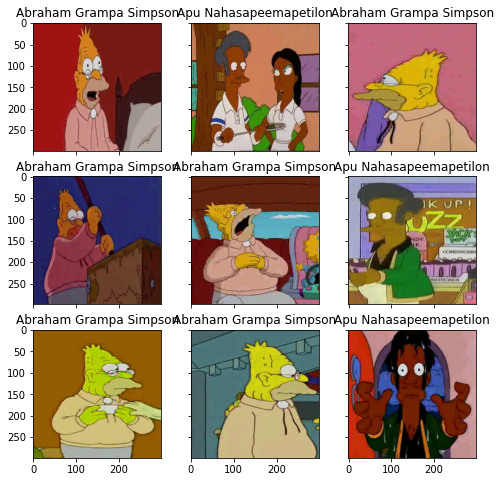

In [ ]:
# функция вывода картинок и названий персонажей
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = new_train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

напишем функции для эпох обучения и валидационных эпох.

In [ ]:
# обучение на одной эпохе
def fit_epoch(model, train_loader, criterion, optimizer):
    # парметры изначально равны 0
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    # проходим по картинкам и их меткам
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # обнуляем градиенты оптимизатора
        optimizer.zero_grad()
        # сбор выходных значений
        outputs = model(inputs)
        # оптимизация и градиентный спуск
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        # реализация затухающей функции потерь
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    # функция потерь и точность эпохи
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    # обнуление парметров
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    # проходим по картинкам валидационной выборки
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # проходим без подсчета градиентов
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        # реализация затухающей функции потерь
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    # функция потерь и точность эпохи
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
# функция самого обучения
def train(train_dataset, val_dataset, model, epochs, batch_size, shuffle=True, sampler=None):
    # загружаем в передатчик данных
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # список для хранения истории изначально пуст и форма для вывода
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    # пройдем по всем эпохам с использованием tqdm и настройкой параметров
    # tqdm - это бар процесса загрузки
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # параметры оптимизатора и функции потерь
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        # пройдем по содержимому эпохи 
        for epoch in range(epochs):
            # сбор и вывод точности и функции потерь
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            # сбор и вывод точности и функции потерь, а также запись их в список
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
# конечная функция предсказания
def predict(model, test_loader):
    # градиенты подсчитываться не будут
    with torch.no_grad():
        logits = []
        # идем по изображениям
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)   
    # массив меток
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
# подсчитаем количество классов для классификации
n_classes = len(np.unique(train_val_labels))
print(n_classes)
# в итоге получилось 42 персонажа

42


Скачаем модель, которая предобучена (для этого поставим перед соответветствующим параметром True)

In [ ]:
from torchvision import models

In [ ]:
# выбор это inception v3
model_incep = models.inception_v3(pretrained=True, aux_logits=False).to(DEVICE)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
# Рассмотрим преобразования этой модели
model_incep

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# рассмотрим слои этой модели
child_counter = 0
for child in model_incep.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

 child 0 is:
BasicConv2d(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
 child 1 is:
BasicConv2d(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
 child 2 is:
BasicConv2d(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
 child 4 is:
BasicConv2d(
  (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
 child 5 is:
BasicConv2d(
  (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0

In [ ]:
# удостоверимся, что все параметры включены для обучения
for param in model_incep.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
# изменим конечный слой, который является полносвязой нейронной сетью, чтобы он
# на выходе давал 42 класса, что соответствует количеству разных персонажей
model_incep.fc = nn.Sequential(nn.Linear(2048,42))
# model_incep.AuxLogits.fc = nn.Linear(768, 42)
model_incep = model_incep.cuda()

In [ ]:
# запустим обучение. Оно происходит достаточно долго, порядка 4 часов
history = train(new_train_dataset, val_dataset, model=model_incep, epochs=24, batch_size=64)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch:   0%|          | 0/24 [00:00<?, ?it/s]

loss 1.015549800256854


epoch:   4%|▍         | 1/24 [09:54<3:47:58, 594.70s/it]


Epoch 001 train_loss: 1.0155     val_loss 0.2798 train_acc 0.7776 val_acc 0.9345
loss 0.27540551979220274


epoch:   8%|▊         | 2/24 [19:38<3:36:54, 591.57s/it]


Epoch 002 train_loss: 0.2754     val_loss 0.1996 train_acc 0.9297 val_acc 0.9505
loss 0.13691620955069175


epoch:  12%|█▎        | 3/24 [29:22<3:26:13, 589.21s/it]


Epoch 003 train_loss: 0.1369     val_loss 0.1419 train_acc 0.9649 val_acc 0.9669
loss 0.10378653574968959


epoch:  17%|█▋        | 4/24 [39:07<3:15:59, 588.00s/it]


Epoch 004 train_loss: 0.1038     val_loss 0.1638 train_acc 0.9727 val_acc 0.9593
loss 0.07090930454302452


epoch:  21%|██        | 5/24 [48:51<3:05:48, 586.74s/it]


Epoch 005 train_loss: 0.0709     val_loss 0.1506 train_acc 0.9810 val_acc 0.9641
loss 0.05586847262989147


epoch:  25%|██▌       | 6/24 [58:35<2:55:43, 585.73s/it]


Epoch 006 train_loss: 0.0559     val_loss 0.1511 train_acc 0.9853 val_acc 0.9637
loss 0.0612494701096512


epoch:  29%|██▉       | 7/24 [1:08:19<2:45:48, 585.21s/it]


Epoch 007 train_loss: 0.0612     val_loss 0.1592 train_acc 0.9834 val_acc 0.9647
loss 0.016067877647600242


epoch:  33%|███▎      | 8/24 [1:18:02<2:35:57, 584.82s/it]


Epoch 008 train_loss: 0.0161     val_loss 0.0968 train_acc 0.9959 val_acc 0.9794
loss 0.008436771683770895


epoch:  38%|███▊      | 9/24 [1:27:45<2:26:02, 584.16s/it]


Epoch 009 train_loss: 0.0084     val_loss 0.0964 train_acc 0.9980 val_acc 0.9794
loss 0.006208613965673103


epoch:  42%|████▏     | 10/24 [1:37:28<2:16:12, 583.76s/it]


Epoch 010 train_loss: 0.0062     val_loss 0.0965 train_acc 0.9987 val_acc 0.9797
loss 0.004423715889990352


epoch:  46%|████▌     | 11/24 [1:47:12<2:06:30, 583.85s/it]


Epoch 011 train_loss: 0.0044     val_loss 0.0967 train_acc 0.9986 val_acc 0.9803
loss 0.003223136148773272


epoch:  50%|█████     | 12/24 [1:56:55<1:56:44, 583.73s/it]


Epoch 012 train_loss: 0.0032     val_loss 0.1034 train_acc 0.9990 val_acc 0.9794
loss 0.002352536257380513


epoch:  54%|█████▍    | 13/24 [2:06:38<1:46:58, 583.53s/it]


Epoch 013 train_loss: 0.0024     val_loss 0.1079 train_acc 0.9992 val_acc 0.9799
loss 0.0024638110644970863


epoch:  58%|█████▊    | 14/24 [2:16:22<1:37:15, 583.60s/it]


Epoch 014 train_loss: 0.0025     val_loss 0.1130 train_acc 0.9993 val_acc 0.9809
loss 0.0015727806220963108


epoch:  62%|██████▎   | 15/24 [2:26:06<1:27:32, 583.56s/it]


Epoch 015 train_loss: 0.0016     val_loss 0.1134 train_acc 0.9997 val_acc 0.9807
loss 0.0015101668417062033


epoch:  67%|██████▋   | 16/24 [2:35:48<1:17:45, 583.22s/it]


Epoch 016 train_loss: 0.0015     val_loss 0.1138 train_acc 0.9996 val_acc 0.9797
loss 0.0014675559780075488


epoch:  71%|███████   | 17/24 [2:45:31<1:08:02, 583.16s/it]


Epoch 017 train_loss: 0.0015     val_loss 0.1147 train_acc 0.9996 val_acc 0.9799
loss 0.0012861694165040697


epoch:  75%|███████▌  | 18/24 [2:55:15<58:20, 583.45s/it]


Epoch 018 train_loss: 0.0013     val_loss 0.1155 train_acc 0.9997 val_acc 0.9797
loss 0.0013368913952276715


epoch:  79%|███████▉  | 19/24 [3:04:58<48:36, 583.33s/it]


Epoch 019 train_loss: 0.0013     val_loss 0.1163 train_acc 0.9996 val_acc 0.9794
loss 0.0012871331978411941


epoch:  83%|████████▎ | 20/24 [3:14:41<38:52, 583.06s/it]


Epoch 020 train_loss: 0.0013     val_loss 0.1174 train_acc 0.9996 val_acc 0.9794
loss 0.0011817329463429155


epoch:  88%|████████▊ | 21/24 [3:24:22<29:07, 582.47s/it]


Epoch 021 train_loss: 0.0012     val_loss 0.1188 train_acc 0.9996 val_acc 0.9794
loss 0.0009980097134653738


epoch:  92%|█████████▏| 22/24 [3:34:05<19:25, 582.55s/it]


Epoch 022 train_loss: 0.0010     val_loss 0.1189 train_acc 0.9997 val_acc 0.9794
loss 0.0010359290267036739


epoch:  96%|█████████▌| 23/24 [3:43:47<09:42, 582.55s/it]


Epoch 023 train_loss: 0.0010     val_loss 0.1190 train_acc 0.9996 val_acc 0.9794
loss 0.0009721070564980247


epoch: 100%|██████████| 24/24 [3:53:29<00:00, 583.74s/it]


Epoch 024 train_loss: 0.0010     val_loss 0.1191 train_acc 0.9998 val_acc 0.9794


In [ ]:
# сохраняем новые веса, чтобы не тратить время на обучение снова, а иметь ту же
# обученную нейросеть локально
import copy
model_24epoch_weights = copy.deepcopy(model_incep.state_dict())
torch.save(model_24epoch_weights, "gdrive/My Drive/model_24epoch_weights.pth")

In [ ]:
# Функция zip() в Python создает итератор, который соединяет элементы
# из двух и более список. Это нужно для вывода графика динамики функции потерь
loss, acc, val_loss, val_acc = zip(*history)

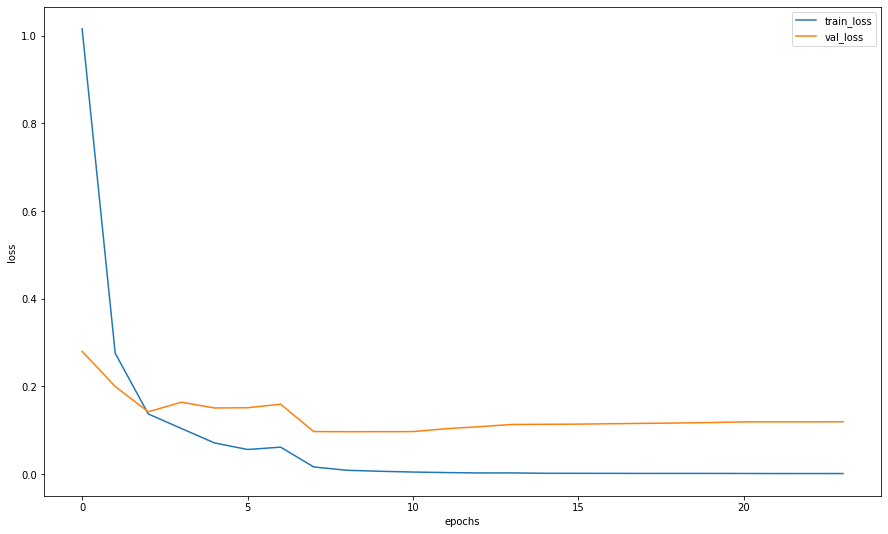

In [ ]:
# печать графика
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Теперь стоит написать функцию для предсказывания результата по 1 картинке, чтобы оценить конечную точность. А позже интегрировать ее в приложение.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    # градиенты подсчитываться не будут, веса меняться не будут
    with torch.no_grad():
        # вычисления будут производиться на доступном устройстве
        inputs = inputs.to(device)
        # переводим в режим предсказаний
        model.eval()
        # вычисление конечного значения класса
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_incep, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_incep, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Метрика, которую мы будем оптимизировать это точность f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

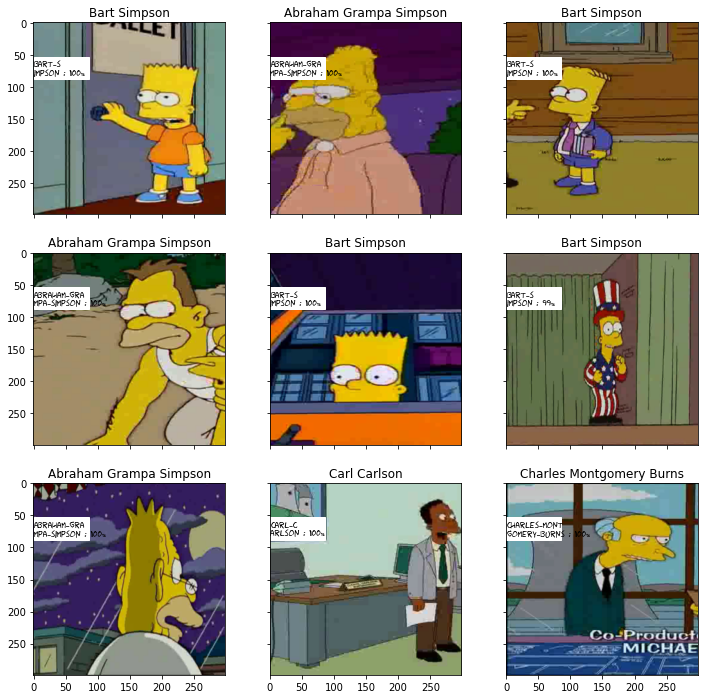

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_incep, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_incep, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/incep_subm.csv', index=False)

In [ ]:
torch.save(model_incep, 'gdrive/My Drive/full_model.pth')

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
